### Package Dependencies

In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Connect to MongoDB

In [2]:
conn = 'mongodb://localhost:27018'
client = pymongo.MongoClient(conn)

### Pull Data

In [3]:
db = client.eliteprospects

metadata = db.meta_data
player_stats = db.player_data
award_stats = db.awards_data

meta = pd.DataFrame(list(metadata.find()))
players = pd.DataFrame(list(player_stats.find()))
awards = pd.DataFrame(list(award_stats.find()))

### Write/Read CSV

In [4]:
# meta.to_csv('meta.csv')
# players.to_csv('players.csv')
# inter.to_csv('international.csv')
# playoffs.to_csv('playoffs.csv')

# meta = pd.read_csv('~/Analytics/ScoutingWithAI/Misc/meta.csv')
# players = pd.read_csv('~/Analytics/ScoutingWithAI/Misc/players.csv')
# inter = pd.read_csv('~/Analytics/ScoutingWithAI/Notebooks/international.csv')

## Wrangling

### Get the age of each player for each season then merge awards with players

#### Set ep_id to int in each table

In [5]:
# ep_id as an integer
players['ep_id'] = players['ep_id'].astype(int)
meta['ep_id'] = meta['ep_id'].astype(int)
awards['ep_id'] = awards['ep_id'].astype(int)

#### Birthdays

In [6]:
# Set aside each players birthday
birthdays = meta[['ep_id', 'date_of_birth']]

# Merge the birthdays with each player row in the players and awards tables
players = pd.merge(players, birthdays, on = 'ep_id', how = 'left')
awards = pd.merge(awards, birthdays, on = 'ep_id', how = 'left')

#### Extract end_of_season var

In [9]:
players = players.drop(players[players['team'] == 'Did not play'].index)
players['end_of_season'] = np.where(players['season'].str.extract(r'-(\d{1})\d{1}') == '9', 
                                    '19' + players['season'].str.extract(r'-(\d{2})') + '-04-05',
                                    '20' + players['season'].str.extract(r'-(\d{2})') + '-04-05')

awards['end_of_season'] = awards['season'].str.extract(r'-(\d{4})') + '-04-05'

In [15]:
# Convert date_of_birth and end_of_season to pandas datetime
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['end_of_season'] = pd.to_datetime(players['end_of_season'])

awards['date_of_birth'] = pd.to_datetime(awards['date_of_birth'])
awards['end_of_season'] = pd.to_datetime(awards['end_of_season'])

# Subtract end_of_season from date_of_birth to get the age of each player at the end of each season
players['age'] = players['end_of_season'] - players['date_of_birth']
awards['age'] = awards['end_of_season'] - awards['date_of_birth']

# Convert the pandas timedelta object to integer years
players['age'] = round(players['age'].dt.days / 365).astype(int)
awards['age'] = round(awards['age'].dt.days / 365)

# Set aside current date
players['current_date'] = pd.to_datetime('today')

# Subtract players birth date from the current date to get the current age
players['current_age'] = players['current_date'] - players['date_of_birth']

# Convert the pandas timedelta to integer years
players['current_age'] = round(players['current_age'].dt.days / 365).astype(int)

# Group awards by ep_id and age
awards_grouped = awards.groupby(['ep_id', 'age']).agg({'award_count': 'sum'}).reset_index()

In [16]:
players = pd.merge(players, awards_grouped, on=['ep_id', 'age'], how='left')

In [22]:
len(players['league'].unique())

629

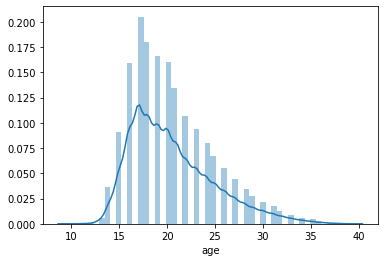

In [20]:
sns.distplot(players['age'])

## Variable Cleaning

In [23]:
players[players['ep_id'] == 11008].sort_values('age')

,_id,ep_id,season,team,league,regular_gp,regular_g,regular_a,regular_pim,regular_pm,team_type,playoffs_gp,playoffs_g,playoffs_a,playoffs_pim,playoffs_pm,date_of_birth,end_of_season,age,current_date,current_age,award_count
51330,5e1912b920b2973d78566f91,11008,1999-00,Sudbury Wolves Minor Bantam AAA,NDMHLB,-,-,-,-,,club,,,,,,1985-09-11,2000-04-05,15,2020-01-11 18:37:07.888809,34,NaN
51331,5e1912b920b2973d78566f94,11008,2000-01,Newmarket Hurricanes,OPJHL,34,3,10,68,,club,,,,,,1985-09-11,2001-04-05,16,2020-01-11 18:37:07.888809,34,NaN
51332,5e1912b920b2973d78566f97,11008,2001-02,Sudbury Wolves,OHL,65,8,6,187,-2,club,5,1,0,24,-1,1985-09-11,2002-04-05,17,2020-01-11 18:37:07.888809,34,NaN
51333,5e1912b920b2973d78566f9a,11008,2002-03,Sudbury Wolves \n“C”,OHL,62,13,16,222,-25,club,,,,,,1985-09-11,2003-04-05,18,2020-01-11 18:37:07.888809,34,NaN
51334,5e1912b920b2973d78566f9d,11008,2003-04,Sudbury Wolves \n“C”,OHL,62,21,16,151,-10,club,7,1,1,14,-1,1985-09-11,2004-04-05,19,2020-01-11 18:37:07.888809,34,NaN
51335,5e1912b920b2973d78566fa0,11008,2003-04,Toronto Roadrunners,AHL,2,0,0,7,2,international,3,0,0,4,1,1985-09-11,2004-04-05,19,2020-01-11 18:37:07.888809,34,NaN
51336,5e1912b920b2973d78566fa3,11008,2004-05,Sudbury Wolves \n“C”,OHL,58,13,27,186,5,club,12,2,5,27,-7,1985-09-11,2005-04-05,20,2020-01-11 18:37:07.888809,34,NaN
51337,5e1912ba20b2973d78566fa6,11008,2005-06,Iowa Stars,AHL,27,2,1,108,6,club,,,,,,1985-09-11,2006-04-05,21,2020-01-11 18:37:07.888809,34,NaN
51338,5e1912ba20b2973d78566fa9,11008,2005-06,Milwaukee Admirals,AHL,37,0,7,153,0,international,17,2,0,19,-1,1985-09-11,2006-04-05,21,2020-01-11 18:37:07.888809,34,NaN
51339,5e1912ba20b2973d78566fac,11008,2006-07,Edmonton Oilers,NHL,29,1,0,105,-7,club,,,,,,1985-09-11,2007-04-05,22,2020-01-11 18:37:07.888809,34,27.0


In [24]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100310 entries, 0 to 100309
Data columns (total 22 columns):
_id              100310 non-null object
ep_id            100310 non-null int64
season           100310 non-null object
team             100310 non-null object
league           100310 non-null object
regular_gp       100310 non-null object
regular_g        100310 non-null object
regular_a        100310 non-null object
regular_pim      100310 non-null object
regular_pm       100310 non-null object
team_type        100310 non-null object
playoffs_gp      100310 non-null object
playoffs_g       100310 non-null object
playoffs_a       100310 non-null object
playoffs_pim     100310 non-null object
playoffs_pm      100310 non-null object
date_of_birth    100310 non-null datetime64[ns]
end_of_season    100310 non-null datetime64[ns]
age              100310 non-null int64
current_date     100310 non-null datetime64[ns]
current_age      100310 non-null int64
award_count      21359 non-n

In [ ]:
# var_dtypes = {
#     'regular_gp': 'int64',
#     'regular_g': 'int64',
#     'regular_a': 'int64',
#     'regular_pim': 'int64',
#     'regular_pm': 'int64',
#     'playoffs_gp': 'int64',
#     'playoffs_g': 'int64',
#     'playoffs_a': 'int64',
#     'playoffs_pim': 'int64',
#     'playoffs_pm': 'int64'
# }

# game_vars = [
#     'regular_gp',
#     'regular_g',
#     'regular_a',
#     'regular_pim',
#     'regular_pm',
#     'playoffs_gp',
#     'playoffs_g',
#     'playoffs_a',
#     'playoffs_pim',
#     'playoffs_pim'
# ]

# players[game_vars] = players[game_vars].replace({'-': 0, '': 0})
# players = players.astype(var_dtypes)

### age

In [25]:
players['age'].unique()

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 16, 29, 30, 31, 32,
       33, 34, 35, 15, 36, 37, 38, 39, 14, 13, 12, 11, 10])

In [ ]:
players[players['age'] == -84]

### regular_gp

In [26]:
players['regular_gp'].unique()

array(['47', '33', '22', '72', '70', '69', '49', '61', '78', '18', '16',
       '3', '13', '7', '1', '36', '34', '50', '6', '75', '65', '81', '56',
       '79', '23', '26', '28', '66', '9', '55', '46', '0', '29', '48',
       '63', '42', '40', '8', '45', '38', '21', '41', '37', '4', '19',
       '31', '57', '58', '67', '51', '10', '54', '5', '52', '15', '17',
       '39', '27', '20', '25', '-', '43', '30', '2', '35', '71', '62',
       '59', '53', '32', '11', '73', '68', '76', '77', '64', '74', '60',
       '14', '12', '24', '44', '80', '82', '117', '85', '83', '84', '95',
       '87', '90', '97', '86', '88'], dtype=object)

In [27]:
players['regular_gp'] = players['regular_gp'].replace({'': 0, '-': 0})
players['regular_gp'] = players['regular_gp'].astype(int)

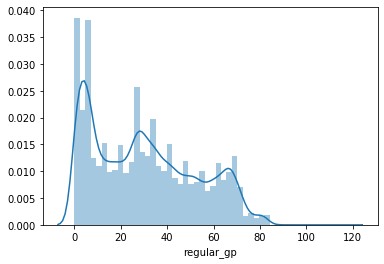

In [28]:
sns.distplot(players['regular_gp'])

### regular_g

In [29]:
players['regular_g'].unique()

array(['1', '9', '12', '44', '46', '45', '17', '30', '5', '7', '4', '3',
       '0', '40', '43', '56', '41', '2', '13', '28', '16', '20', '25',
       '10', '11', '22', '8', '24', '36', '15', '14', '6', '19', '32',
       '27', '31', '57', '51', '-', '21', '38', '34', '39', '23', '26',
       '35', '33', '18', '37', '42', '48', '29', '47', '50', '118', '53',
       '113', '54', '59', '69', '70', '49', '130', '58', '97', '77', '61',
       '63', '80', '79', '52', '55', '60', '84', '76', '71', '75', '66',
       '68', '62', '90', '120', '72', '64', '138', '86', '65', '119',
       '124', '83', '100', '88', '78', '81', '94', '95', '91', '105',
       '73', '67', '96', '142', '82'], dtype=object)

In [30]:
players['regular_g'] = players['regular_g'].replace({'': 0, '-': 0})
players['regular_g'] = players['regular_g'].astype(int)

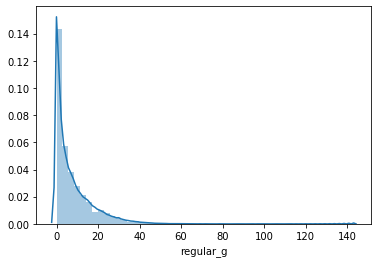

In [31]:
sns.distplot(players['regular_g'])

### regular_a

In [32]:
players['regular_a'].unique()

array(['1', '9', '38', '53', '62', '22', '21', '31', '5', '3', '10', '2',
       '0', '50', '30', '26', '37', '25', '12', '4', '8', '42', '7', '11',
       '40', '14', '36', '44', '59', '19', '17', '27', '15', '23', '34',
       '18', '28', '35', '39', '13', '24', '33', '16', '41', '6', '-',
       '20', '58', '57', '48', '32', '54', '47', '51', '46', '29', '45',
       '52', '55', '70', '65', '43', '49', '61', '77', '66', '120', '75',
       '64', '72', '56', '85', '73', '102', '69', '82', '83', '63', '129',
       '76', '67', '80', '78', '79', '74', '60', '84', '68', '88', '86',
       '87', '96', '126', '89', '95', '71', '93', '98', '81', '90', '157',
       '110', '92', '91', '108', '118', '106', '146', '137', '105', '130',
       '94'], dtype=object)

In [33]:
players['regular_a'] = players['regular_a'].replace({'': 0, '-': 0})
players['regular_a'] = players['regular_a'].astype(int)

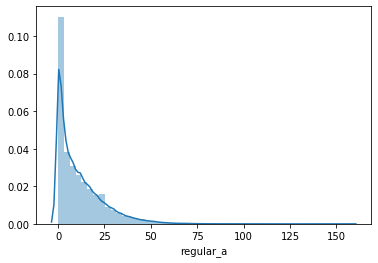

In [34]:
sns.distplot(players['regular_a'])

### regular_pim

In [35]:
players['regular_pim'].unique()

array(['23', '19', '17', '38', '66', '100', '35', '41', '34', '68', '20',
       '12', '2', '4', '10', '0', '40', '47', '39', '95', '82', '27',
       '28', '58', '48', '45', '18', '14', '44', '26', '36', '72', '73',
       '24', '32', '6', '43', '30', '8', '16', '85', '13', '91', '33',
       '46', '52', '22', '63', '65', '60', '9', '29', '21', '-', '59',
       '110', '55', '83', '54', '111', '50', '37', '86', '75', '51', '53',
       '113', '42', '104', '130', '80', '93', '25', '56', '49', '62',
       '79', '105', '101', '81', '76', '103', '122', '124', '84', '64',
       '61', '108', '89', '70', '7', '139', '74', '131', '78', '31', '92',
       '69', '97', '90', '88', '71', '57', '168', '202', '137', '169',
       '192', '94', '123', '102', '115', '127', '133', '96', '98', '118',
       '112', '15', '107', '117', '185', '67', '149', '251', '214', '172',
       '272', '216', '266', '116', '5', '121', '138', '151', '153', '114',
       '120', '145', '243', '275', '158', '186', '179'

In [36]:
players['regular_pim'] = players['regular_pim'].replace({'': 0, '-': 0})
players['regular_pim'] = players['regular_pim'].astype(int)

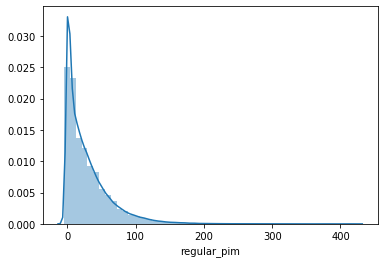

In [37]:
sns.distplot(players['regular_pim'])

### regular_pm

In [38]:
players['regular_pm'].unique()

array(['-8', '-3', '2', '-5', '-9', '0', '-13', '1', '-2', '', '-6', '4',
       '11', '-1', '10', '-29', '3', '-4', '-7', '8', '-15', '-10', '12',
       '-23', '-19', '5', '25', '15', '16', '7', '21', '18', '-16', '6',
       '52', '89', '-14', '19', '-11', '-21', '17', '-12', '27', '22',
       '14', '31', '-18', '13', '20', '24', '29', '9', '-24', '-22', '37',
       '30', '-20', '-30', '23', '-42', '34', '-26', '40', '44', '45',
       '32', '28', '-17', '42', '-25', '-28', '39', '-60', '26', '33',
       '35', '-32', '-35', '-27', '43', '36', '-41', '56', '-33', '-36',
       '60', '-31', '-48', '-37', '-40', '-34', '07', '38', '-39', '61',
       '47', '59', '46', '-47', '-38', '-50', '48', '41', '50', '64',
       '-43', '-51', '55', '113', '62', '-62', '73', '-46', '65', '-52',
       '57', '-77', '71', '-61', '72', '67', '51', '-49', '131', '49',
       '53', '-55', '70', '90', '76', '58', '68', '63', '54', '108',
       '114', '96', '66', '-69', '-45', '-59', '-57', '-44', '

In [39]:
players['regular_pm'] = players['regular_pm'].replace({'': 0, '-': 0})
players['regular_pm'] = players['regular_pm'].astype(int)

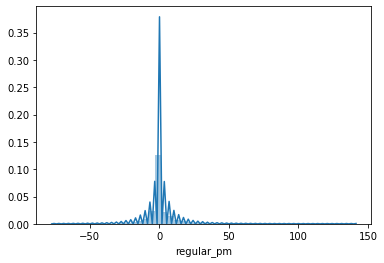

In [40]:
sns.distplot(players['regular_pm'])

### playoffs_gp

In [41]:
players['playoffs_gp'].unique()

array(['', '4', '5', '3', '1', '-', '11', '12', '16', '17', '6', '7',
       '10', '2', '15', '21', '14', '9', '8', '23', '19', '22', '13',
       '18', '20', '24', '26', '25', '0', '27', '32', '33', '28'],
      dtype=object)

In [42]:
players['playoffs_gp'] = players['playoffs_gp'].replace({'': 0, '-': 0})
players['playoffs_gp'] = players['playoffs_gp'].astype(int)

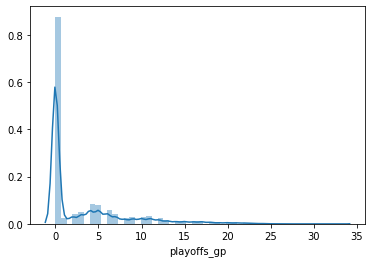

In [43]:
sns.distplot(players['playoffs_gp'])

### playoffs_g

In [44]:
players['playoffs_g'].unique()

array(['', '1', '0', '-', '4', '3', '9', '2', '6', '7', '10', '5', '14',
       '17', '8', '11', '12', '19', '13', '24', '15', '16', '20', '01',
       '18', '25', '22', '23', '21', '29'], dtype=object)

In [45]:
players['playoffs_g'] = players['playoffs_g'].replace({'': 0, '-': 0})
players['playoffs_g'] = players['playoffs_g'].astype(int)

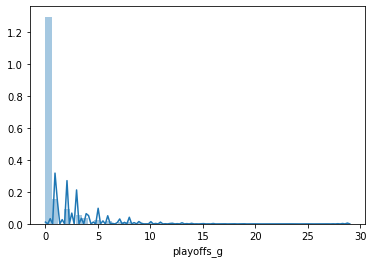

In [46]:
sns.distplot(players['playoffs_g'])

### playoffs_a

In [47]:
players['playoffs_a'].unique()

array(['', '0', '1', '2', '-', '11', '9', '6', '3', '4', '10', '5', '7',
       '8', '12', '20', '15', '13', '14', '17', '16', '21', '24', '19',
       '29', '23', '18', '27', '22', '25', '37', '30', '26', '40', '31',
       '28', '34'], dtype=object)

In [48]:
players['playoffs_a'] = players['playoffs_a'].replace({'': 0, '-': 0})
players['playoffs_a'] = players['playoffs_a'].astype(int)

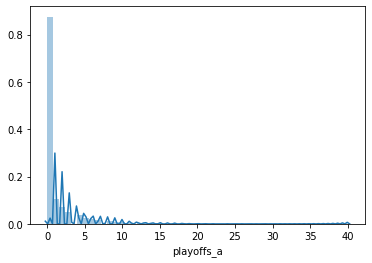

In [49]:
sns.distplot(players['playoffs_a'])

### playoffs_pim

In [50]:
players['playoffs_pim'].unique()

array(['', '0', '6', '4', '2', '-', '20', '27', '31', '5', '10', '14',
       '18', '16', '28', '8', '17', '39', '12', '26', '9', '37', '11',
       '13', '21', '25', '32', '34', '44', '59', '30', '22', '24', '29',
       '40', '15', '7', '38', '68', '35', '58', '49', '41', '46', '54',
       '77', '36', '48', '19', '50', '45', '42', '33', '56', '62', '51',
       '23', '55', '43', '52', '-3', '53', '64', '47', '3', '82', '86',
       '60', '84', '61', '63', '72', '70', '1', '-2', '85', '66', '75',
       '65', '-1', '57', '73', '71', '87', '78', '79', '81', '98', '90',
       '67', '88', '74', '102', '00', '76', '69', '94', '108'],
      dtype=object)

In [51]:
players['playoffs_pim'] = players['playoffs_pim'].replace({'': 0, '-': 0})
players['playoffs_pim'] = players['playoffs_pim'].astype(int)

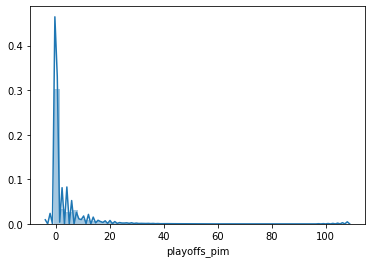

In [52]:
sns.distplot(players['playoffs_pim'])

### playoffs_pm

In [53]:
players['playoffs_pm'].unique()

array(['', '-6', '-4', '-3', '0', '1', '-5', '9', '-1', '-2', '11', '6',
       '3', '2', '4', '8', '20', '5', '7', '-7', '10', '15', '-8', '14',
       '-11', '-12', '-9', '12', '13', '23', '16', '18', '17', '-10',
       '24', '45', '-14', '19', '22', '-0', '26', '29', '-13', '21', '30',
       '28', '27', '31', '33'], dtype=object)

In [54]:
players['playoffs_pm'] = players['playoffs_pm'].replace({'': 0, '-': 0})
players['playoffs_pm'] = players['playoffs_pm'].astype(int)

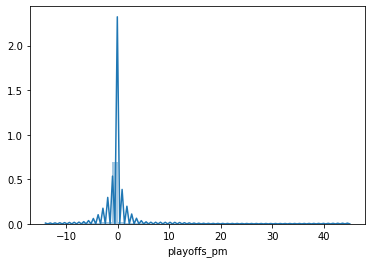

In [55]:
sns.distplot(players['playoffs_pm'])

### Inspect

In [56]:
players.sample(10)

,_id,ep_id,season,team,league,regular_gp,regular_g,regular_a,regular_pim,regular_pm,team_type,playoffs_gp,playoffs_g,playoffs_a,playoffs_pim,playoffs_pm,date_of_birth,end_of_season,age,current_date,current_age,award_count
28488,5e19020020b2973d785490b0,11100,2017-18,Dinamo Riga,KHL,6,0,0,4,-1,club,0,0,0,0,0,1989-02-12,2018-04-05,29,2020-01-11 18:37:07.888809,31,NaN
22531,5e18fd6720b2973d78542dbf,11863,2013-14,Sibir Novosibirsk,KHL,49,0,1,27,-9,club,3,0,0,0,0,1989-08-08,2014-04-05,25,2020-01-11 18:37:07.888809,30,NaN
28056,5e1901c920b2973d78548646,14495,2008-09,Ottawa Senators,NHL,1,0,0,0,0,club,0,0,0,0,0,1988-04-05,2009-04-05,21,2020-01-11 18:37:07.888809,32,NaN
98370,5e19368520b2973d785a27c3,151144,2013-14,Val-d'Or Foreurs,QMJHL,68,10,31,36,13,club,24,6,4,10,8,1995-11-15,2014-04-05,18,2020-01-11 18:37:07.888809,24,12.0
26115,5e19005e20b2973d78546272,11694,2007-08,Houston Aeros,AHL,6,1,1,2,1,club,0,0,0,0,0,1986-07-20,2008-04-05,22,2020-01-11 18:37:07.888809,34,NaN
88413,5e192efc20b2973d78596c30,56051,2017-18,Elsipogtog Hawks,NESHL,6,0,2,8,0,club,11,0,2,20,0,1993-01-19,2018-04-05,25,2020-01-11 18:37:07.888809,27,14.0
39595,5e190a2d20b2973d7855a117,11392,2013-14,AIK,SHL,54,5,12,40,-11,club,10,2,2,10,-2,1987-03-17,2014-04-05,27,2020-01-11 18:37:07.888809,33,NaN
3170,5e18efce20b2973d7852ced9,13800,2006-07,Beardy's Blackhawks,SMHL,42,34,51,91,0,club,4,1,3,0,0,1989-01-01,2007-04-05,18,2020-01-11 18:37:07.888809,31,NaN
75223,5e19249420b2973d78586db5,385332,2018-19,Blainville-Boisbriand Armada,QMJHL,11,0,0,25,-8,international,0,0,0,0,0,2000-11-20,2019-04-05,18,2020-01-11 18:37:07.888809,19,NaN
4251,5e18f06e20b2973d7852e44d,85089,2014-15,Swift Current Broncos,WHL,2,0,0,0,-2,club,0,0,0,0,0,1994-10-15,2015-04-05,20,2020-01-11 18:37:07.888809,25,NaN


### Reshape quantitative data

In [ ]:
new_df = pd.DataFrame()

ids = players['ep_id'].unique()

for id in ids:
        
    df = players[players['ep_id'] == id]

    df = df.groupby(['age', 'ep_id']).agg({
            'regular_gp': 'sum', 
            'regular_g': 'sum', 
            'regular_a': 'sum', 
            'regular_pim': 'sum',
            'regular_pm': 'mean',
            'playoffs_g': 'sum',
            'playoffs_a': 'sum',
            'playoffs_pim': 'sum',
            'playoffs_pm': 'mean',
            'award_count': 'sum'
        }).reset_index() 

    df = df.pivot('ep_id', 'age')
    
    #Column Labels    
    
    #Manage the pandas multiindex to re-label each column for each stat and age
    df.columns = [''.join(str(col)) for col in df.columns]    
    
    # Rename column labels for clarity
    labels = []

    for col in df:

        label = re.findall(r"'(.+)'", col)
        stat = re.findall(r',\s(\d{2})', col)

        labels.append(label[0] + '_' + stat[0])
        
    df.columns = labels
    
    #Append each row of player data to the last
    new_df = pd.concat([new_df, df], axis=0, sort=False)

### Reshape qualitative

In [62]:
ids = players['ep_id'].unique()

qual_df = pd.DataFrame()

for id in ids:
    
    df = players[players['ep_id'] == id].reset_index().sort_values('age')
    df = df.drop(['index', '_id'], 1).drop_duplicates()
    
    ages = []
    teams = []
    leagues = []
    age_test = []

    high_gp = 0

    for row in df.iterrows():    

        if row[1]['age'] not in age_test:

            age_test.append(row[1]['age'])

            age = row[1]['age']
            team = row[1]['team']
            league = row[1]['league']

            high_gp = int(row[1]['regular_gp'])

            ages.append(age)
            teams.append(team)
            leagues.append(league)

        elif row[1]['age'] in age_test:

            if int(row[1]['regular_gp']) > high_gp:

                age = row[1]['age']
                team = row[1]['team']
                league = row[1]['league']

                high_gp = int(row[1]['regular_gp'])

                ages = ages[:-1]
                teams = teams[:-1]
                leagues = leagues[:-1]

                ages.append(age)
                teams.append(team)
                leagues.append(league)

    test_df = pd.DataFrame(zip(ages, teams, leagues), columns=['age', 'team', 'league'])

    test_df['ep_id'] = row[1]['ep_id']

    test_df = test_df.pivot('ep_id', 'age')

    test_df.columns = [''.join(str(col)) for col in test_df.columns]

    # Rename column labels for clarity
    labels = []

    for col in test_df:

        label = re.findall(r"'(.+)'", col)
        stat = re.findall(r',\s(\d{2})', col)

        labels.append(label[0] + '_' + stat[0])

    test_df.columns = labels
    
    qual_df = pd.concat([qual_df, test_df], axis=0, sort=False)

### Merge qualitative and quantitative dataframes

In [64]:
combined = pd.merge(new_df, qual_df, on='ep_id', how='left').reset_index()

### Combine Meta and Combined dataframes

In [65]:
main = pd.merge(meta, combined, on = 'ep_id', how = 'left')
    
main = main.reset_index()
main = round(main.drop(['_id', 'index'], 1))

In [66]:
main.head()

,ep_id,full_name,date_of_birth,hometown,country,youth_team,position,height,weight,shoots,status,scout_text,regular_gp_17,regular_gp_18,regular_gp_19,regular_gp_20,regular_gp_21,regular_gp_22,regular_gp_23,regular_gp_24,regular_gp_25,regular_gp_26,regular_gp_27,regular_gp_28,regular_g_17,regular_g_18,regular_g_19,regular_g_20,regular_g_21,regular_g_22,regular_g_23,regular_g_24,regular_g_25,regular_g_26,regular_g_27,regular_g_28,regular_a_17,regular_a_18,regular_a_19,regular_a_20,regular_a_21,regular_a_22,regular_a_23,regular_a_24,regular_a_25,regular_a_26,regular_a_27,regular_a_28,regular_pim_17,regular_pim_18,regular_pim_19,regular_pim_20,regular_pim_21,regular_pim_22,regular_pim_23,regular_pim_24,regular_pim_25,regular_pim_26,regular_pim_27,regular_pim_28,regular_pm_17,regular_pm_18,regular_pm_19,regular_pm_20,regular_pm_21,regular_pm_22,regular_pm_23,regular_pm_24,regular_pm_25,regular_pm_26,regular_pm_27,regular_pm_28,playoffs_g_17,playoffs_g_18,playoffs_g_19,playoffs_g_20,playoffs_g_21,playoffs_g_22,playoffs_g_23,playoffs_g_24,playoffs_g_25,playoffs_g_26,playoffs_g_27,playoffs_g_28,playoffs_a_17,playoffs_a_18,playoffs_a_19,playoffs_a_20,playoffs_a_21,playoffs_a_22,playoffs_a_23,playoffs_a_24,playoffs_a_25,playoffs_a_26,playoffs_a_27,playoffs_a_28,playoffs_pim_17,playoffs_pim_18,playoffs_pim_19,playoffs_pim_20,playoffs_pim_21,playoffs_pim_22,playoffs_pim_23,playoffs_pim_24,playoffs_pim_25,playoffs_pim_26,playoffs_pim_27,playoffs_pim_28,playoffs_pm_17,playoffs_pm_18,playoffs_pm_19,playoffs_pm_20,playoffs_pm_21,playoffs_pm_22,playoffs_pm_23,playoffs_pm_24,playoffs_pm_25,playoffs_pm_26,playoffs_pm_27,playoffs_pm_28,award_count_17,award_count_18,award_count_19,award_count_20,award_count_21,award_count_22,award_count_23,award_count_24,award_count_25,award_count_26,award_count_27,award_count_28,regular_gp_16,regular_gp_29,regular_gp_30,regular_gp_31,regular_gp_32,regular_gp_33,regular_gp_34,regular_gp_35,regular_g_16,regular_g_29,regular_g_30,regular_g_31,regular_g_32,regular_g_33,regular_g_34,regular_g_35,regular_a_16,regular_a_29,regular_a_30,regular_a_31,regular_a_32,regular_a_33,regular_a_34,regular_a_35,regular_pim_16,regular_pim_29,regular_pim_30,regular_pim_31,regular_pim_32,regular_pim_33,regular_pim_34,regular_pim_35,regular_pm_16,regular_pm_29,regular_pm_30,regular_pm_31,regular_pm_32,regular_pm_33,regular_pm_34,regular_pm_35,playoffs_g_16,playoffs_g_29,playoffs_g_30,playoffs_g_31,playoffs_g_32,playoffs_g_33,playoffs_g_34,playoffs_g_35,playoffs_a_16,playoffs_a_29,playoffs_a_30,playoffs_a_31,playoffs_a_32,playoffs_a_33,playoffs_a_34,playoffs_a_35,playoffs_pim_16,playoffs_pim_29,playoffs_pim_30,playoffs_pim_31,playoffs_pim_32,playoffs_pim_33,playoffs_pim_34,playoffs_pim_35,playoffs_pm_16,playoffs_pm_29,playoffs_pm_30,playoffs_pm_31,playoffs_pm_32,playoffs_pm_33,playoffs_pm_34,playoffs_pm_35,award_count_16,award_count_29,award_count_30,award_count_31,award_count_32,award_count_33,award_count_34,award_count_35,regular_gp_15,regular_gp_36,regular_g_15,regular_g_36,regular_a_15,regular_a_36,regular_pim_15,regular_pim_36,regular_pm_15,regular_pm_36,playoffs_g_15,playoffs_g_36,playoffs_a_15,playoffs_a_36,playoffs_pim_15,playoffs_pim_36,playoffs_pm_15,playoffs_pm_36,award_count_15,award_count_36,regular_gp_37,regular_gp_38,regular_gp_39,regular_g_37,regular_g_38,regular_g_39,regular_a_37,regular_a_38,regular_a_39,regular_pim_37,regular_pim_38,regular_pim_39,regular_pm_37,regular_pm_38,regular_pm_39,playoffs_g_37,playoffs_g_38,playoffs_g_39,playoffs_a_37,playoffs_a_38,playoffs_a_39,playoffs_pim_37,playoffs_pim_38,playoffs_pim_39,playoffs_pm_37,playoffs_pm_38,playoffs_pm_39,award_count_37,award_count_38,award_count_39,regular_gp_14,regular_g_14,regular_a_14,regular_pim_14,regular_pm_14,playoffs_g_14,playoffs_a_14,playoffs_pim_14,playoffs_pm_14,award_count_14,regular_gp_13,regular_g_13,regular_a_13,regular_pim_13,regular_pm_13,playoffs_g_13,playoffs_a_13,playoffs_pim_13,playoffs_pm_13,award_count_13,regular_gp_12,regular_g_12,regul

### Save and inspect data

In [67]:
main.to_csv('main.csv')